In [235]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pylab as pl, itertools as it
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *
from proj1_helpers import *

# 1. Choosing a model

Simple linear model:
$y = w_1x_1+\dots + w_nx_n$

In [277]:
feature_cols = [1, 3, 4, 8, 10, 11, 12, 13, 22]
# feature_cols = [0, 1, 2, 7, 10, 11, 13, 19]
N_VALID_FEATURES = len(feature_cols)

In [234]:
y, inputs_or, ids = load_csv_data("full_train_data.csv", True)
print(y.shape)
print(inputs_or.shape)
print(ids.shape)
y

(5000,)
(5000, 30)
(5000,)


array([ 1., -1., -1., ...,  1., -1.,  1.])

In [237]:
y_TEST, inputs_TEST, ids_TEST = load_csv_data("full_train_data.csv", False)

In [238]:
inputs_m = np.mean(inputs_or,0)
inputs_st = np.std(inputs_or,0)

inputs = (inputs_or - inputs_m)/inputs_st
print(inputs.shape)


(5000, 30)


In [239]:
print("Mean: ", np.mean(inputs,0))
print("Std: ", np.std(inputs,0))

Mean:  [-1.68484560e-14  5.24646993e-16 -3.01493275e-15  9.61042357e-16
  5.70302340e-14  1.20398595e-13  2.88899703e-14 -8.44023740e-15
  1.59816604e-15 -3.63102881e-15 -2.17299512e-15 -4.50195436e-16
  3.07967735e-14  3.18871596e-15 -2.13606910e-17  3.68594044e-18
  8.12188095e-15  2.12274642e-17 -3.57969210e-16  1.96758165e-15
 -6.68687328e-17 -3.99769107e-15 -5.20958277e-17 -5.78745940e-15
 -7.10720371e-16  9.47686374e-17 -9.58340985e-14 -5.47300920e-17
  3.30661887e-15  7.94558863e-16]
Std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [240]:
N_FEATURES = inputs_or.shape[1]
N_DATA = len(inputs_or)

In [241]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    x_te = x[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    x_tr = np.delete(x, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    Phi_tr = build_poly(x_tr, degree)
    Phi_te = build_poly(x_te, degree)
    # form data with polynomial degree: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, Phi_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, Phi_te, w)
    loss_tr = compute_mse(y_tr, Phi_tr, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

In [242]:
x = inputs[:,feature_cols]
degree = 1
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


#tx = build_poly(x, degree)
#y_test = tx @ w
#y_test[y_test >= 0] = 1
#y_test[y_test < 0] = -1


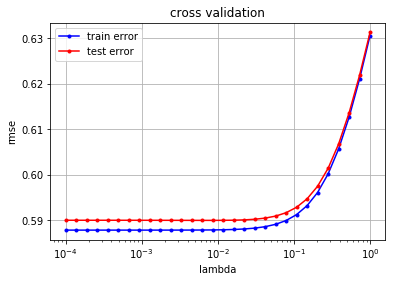

In [243]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [244]:
np.argmin(rmse_te)

13

In [245]:
x_TEST = inputs_TEST[:,feature_cols]
k_indices = build_k_indices(y_TEST, 2, 1)
y_test = y_TEST[k_indices[0]]    
x_test = x_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
x_train = np.delete(x_TEST, k_indices[0], axis=0)
tx_tr = build_poly(x_train, degree)
tx_te = build_poly(x_test, degree)


weights, mse = ridge_regression(y_train, tx_tr, lambdas[np.argmin(rmse_te)])


In [246]:
weights

array([-4.80873160e-01, -7.04727671e-03,  1.29094300e-04,  1.00267927e-01,
       -1.40622465e-03, -2.72474000e-02,  1.10483791e-01,  2.23576447e-01,
        6.68438430e-03, -1.32953703e-02])

In [247]:
y_pred = predict_labels(weights, tx_te)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_tr, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_te, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)


Total correct: 90329.0 
Total incorrect: 34671.0 
Correct percentage: 72.26320000000001 %
-----------------------------
Train RMSE: 0.8482002388076008 , Test RMSE: 0.8489966563103399


4-th order linear model:
$y = w_0+w_1x_1+\dots+ w_nx_1^n +\dots$

In [248]:
x = inputs[:,feature_cols]
degree = 4
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


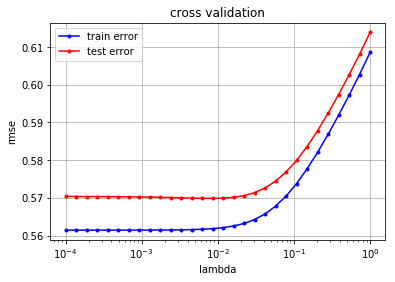

In [249]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [250]:
np.argmin(rmse_te)

14

In [251]:
x_TEST = inputs_TEST[:,feature_cols]
k_indices = build_k_indices(y, 2, 18)
y_test = y_TEST[k_indices[0]]    
x_test = x_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
x_train = np.delete(x_TEST, k_indices[0], axis=0)
tx_tr = build_poly(x_train, degree)
tx_te = build_poly(x_test, degree)

print(tx_tr.shape)
weights, mse = ridge_regression(y_train, tx_tr, lambdas[np.argmin(rmse_te)])


(247500, 37)


In [252]:
y_pred = predict_labels(weights, tx_te)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_tr, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_te, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 1927.0 
Total incorrect: 573.0 
Correct percentage: 77.08 %
-----------------------------
Train RMSE: 0.8182367571755403 , Test RMSE: 0.7934685898866635


A more complicated model:
Order 2:
$y=w_0 + w_1x_1 + w_2x_2 +w_3x_1^2 +w_4x_2^2+w_5x_1x_2+\dots$

In [278]:
def cross_validation_poly(y, tx, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    tx_te = tx[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    tx_tr = np.delete(tx, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, tx_te, w)
    loss_tr = compute_mse(y_tr, tx_tr, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

def build_poly_plus(y, x, degree):
    poly = np.ones((len(x), 1))

    for deg in range(1, degree+1):
        if deg == 1:
            poly = np.c_[poly, x]
        else:
            for i in it.combinations_with_replacement(range(x.shape[1]),degree):
                poly = np.c_[poly, np.prod(x[:,i],1)]
    return poly

In [285]:
x = inputs[:,feature_cols]
degree = 2
tx = build_poly_plus(y, x, degree)

In [286]:
k_fold = 4
lambdas = np.logspace(-4, 0, 30)

rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    print(l)
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation_poly(y, tx, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))



0.0001
0.00013738237958832623
0.00018873918221350977
0.0002592943797404667
0.0003562247890262444
0.0004893900918477494
0.0006723357536499335
0.0009236708571873865
0.0012689610031679222
0.0017433288221999873
0.002395026619987486
0.0032903445623126675
0.004520353656360241
0.006210169418915616
0.008531678524172805
0.011721022975334805
0.01610262027560939
0.02212216291070448
0.03039195382313198
0.041753189365604
0.05736152510448681
0.07880462815669913
0.1082636733874054
0.14873521072935117
0.20433597178569418
0.2807216203941176
0.38566204211634725
0.5298316906283708
0.7278953843983146
1.0


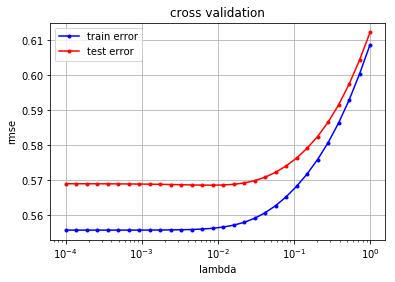

In [287]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [288]:
np.argmin(rmse_te)

14

In [289]:
tx_TEST = build_poly_plus(y_TEST, inputs_TEST[:,feature_cols], degree)

k_indices = build_k_indices(y_TEST, 2, 17)
y_test = y_TEST[k_indices[0]]    
tx_test = tx_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
tx_train = np.delete(tx_TEST, k_indices[0], axis=0)

print(tx_train.shape)
weights, mse = ridge_regression(y_train, tx_train, lambdas[np.argmin(rmse_te)])


(125000, 55)


In [290]:
y_pred = predict_labels(weights, tx_test)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 93915.0 
Total incorrect: 31085.0 
Correct percentage: 75.132 %
-----------------------------
Train RMSE: 0.813619403791786 , Test RMSE: 0.875458132326284


# Test set

In [348]:
y_test, inputs_test, ids_test = load_csv_data('test.csv', sub_sample=False)

In [349]:
print('Proportion of missing data in each feature: \n', np.count_nonzero(inputs_test== -999,0)/len(y_test) )

Proportion of missing data in each feature: 
 [0.15220383 0.         0.         0.         0.70885087 0.70885087
 0.70885087 0.         0.         0.         0.         0.
 0.70885087 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.4002865
 0.4002865  0.4002865  0.70885087 0.70885087 0.70885087 0.        ]


In [350]:
np.mean(inputs_test[:,feature_cols],0)

array([ 4.92583872e+01,  5.78290937e+01, -7.07441800e+02,  1.89926203e+01,
        1.43928858e+00, -1.26825167e-01, -7.08008508e+02,  3.86940752e+01,
        9.80251233e-01])

In [351]:
input_data_na = inputs_test.copy()
for col in feature_cols: 
    input_data_na = input_data_na[~(input_data_na[:,col]==-999)]
mean = np.mean(input_data_na,0)
for i in feature_cols:
    if any(inputs_test[:,i] == -999):
        np.place(inputs_test[:,i], inputs_test[:,i] == -999, mean[i])

In [352]:
np.mean(inputs_test[:,feature_cols],0)

array([49.25838724, 57.8290937 ,  2.40501628, 18.99262028,  1.43928858,
       -0.12682517,  0.4585633 , 38.69407516,  0.98025123])

In [175]:
tx_test = build_poly(inputs_test[:,feature_cols], degree)
tx_test.shape
#tx = build_poly_plus(y, inputs_test[:,feature_cols], degree)

(568238, 10)

In [176]:
y_pred = predict_labels(weights, tx)
y_pred.shape

(568238,)

In [178]:
create_csv_submission(ids_test, y_pred, 'prediction.csv')


In [52]:
Result=pd.read_csv('prediction.csv')
len(Result)

568238